In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# =============================================================================
# 1. Load Data and Preprocessing
# =============================================================================

# Load the dataset
df = pd.read_csv("../data/Video_Timeseries.csv")
print(f"Original shape: {df.shape}")

# Handle missing values strategically instead of dropping all rows
df_clean = df.copy()

# Fill missing values based on column type
for col in df.columns:
    if col.startswith(('views', 'impressions')):
        # For view/impression metrics, use median
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    elif col.startswith(('like', 'comment')):
        # For engagement metrics, missing likely means zero
        df_clean[col] = df_clean[col].fillna(0)

# Only drop rows where target is missing
if 'views_final' in df_clean.columns:
    df_clean = df_clean.dropna(subset=['views_final'])
else:
    # If views_final is not available, use views3s_5k as proxy
    df_clean['views_final'] = df_clean['views3s_5k']
    df_clean = df_clean.dropna(subset=['views_final'])

print(f"Clean shape: {df_clean.shape}")

# Basic data validation
def validate_data(df):
    # Check for negative values in metrics that should be positive
    for col in df.columns:
        if col.startswith(('views', 'impressions', 'like', 'comment')) and (df[col] < 0).any():
            print(f"Warning: Negative values found in {col}, replacing with zeros")
            df[col] = df[col].clip(lower=0)

    # Check for unrealistic ratios
    for prefix in ['1k', '5k']:
        col_views = f'views3s_{prefix}'
        col_imp = f'impressions_{prefix}'
        if col_views in df.columns and col_imp in df.columns:
            ratio = df[col_views] / df[col_imp].replace(0, np.nan)
            if (ratio > 1).any():
                print(f"Warning: Some videos have more views than impressions at {prefix}")
    return df

df_clean = validate_data(df_clean)

Original shape: (18468, 15)
Clean shape: (18468, 15)


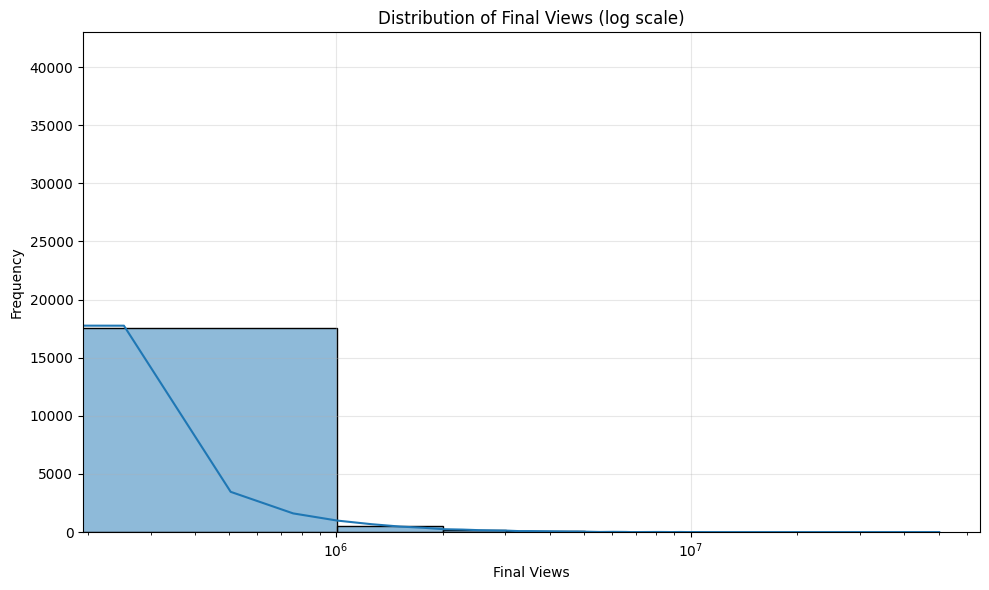

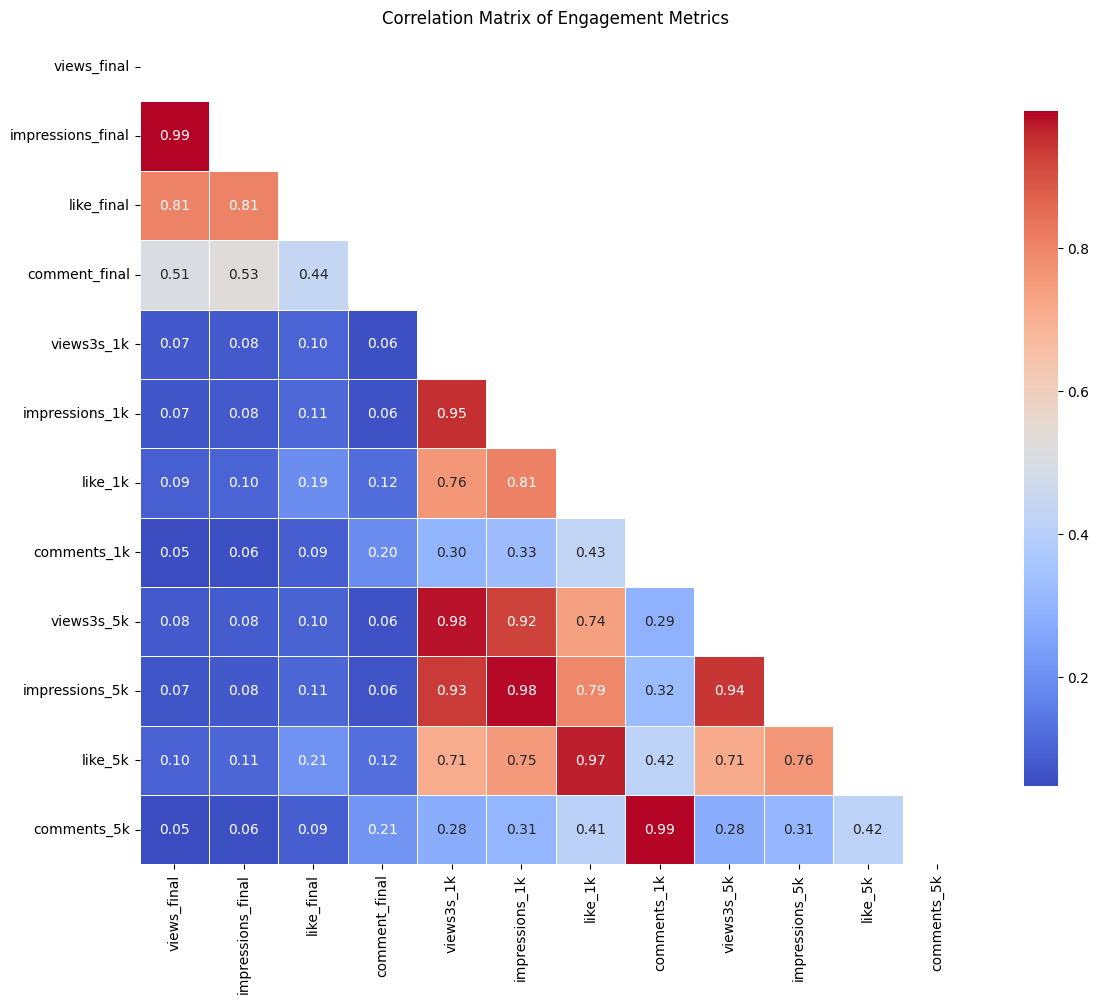

In [ ]:
# =============================================================================
# 2. Exploratory Data Analysis
# =============================================================================

# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['views_final'], bins=50, kde=True)
plt.xscale("log")
plt.title("Distribution of Final Views (log scale)")
plt.xlabel("Final Views")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation analysis of key metrics
engagement_cols = [col for col in df_clean.columns if any(x in col for x in ['views', 'like', 'comment', 'impressions'])]
corr_matrix = df_clean[engagement_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Engagement Metrics")
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 3. Feature Engineering
# =============================================================================

# Create a function for feature engineering to keep code organized
def engineer_features(df):
    # Add epsilon to prevent division by zero
    epsilon = 1e-5

    # 1. Normalize metrics by impressions
    for prefix in ['1k', '5k']:
        imp_col = f'impressions_{prefix}'
        if imp_col in df.columns:
            # Normalize views, likes, comments by impressions
            for metric in ['views3s', 'like', 'comments']:
                col = f'{metric}_{prefix}'
                if col in df.columns:
                    df[f'norm_{col}'] = df[col] * 1000 / (df[imp_col] + epsilon)

    # 2. Create rate features
    # Open rates (views per impression)
    df['openrate3s_1k'] = df['views3s_1k'] / (df['impressions_1k'] + epsilon)
    df['openrate3s_5k'] = df['views3s_5k'] / (df['impressions_5k'] + epsilon)

    # Engagement rates (likes per view)
    df['engrate_1k'] = df['like_1k'] / (df['views3s_1k'] + epsilon)
    df['engrate_5k'] = df['like_5k'] / (df['views3s_5k'] + epsilon)

    # Comment ratios (comments per like)
    df['commentratio_1k'] = df['comments_1k'] / (df['like_1k'] + epsilon)
    df['commentratio_5k'] = df['comments_5k'] / (df['like_5k'] + epsilon)

    # 3. Growth and trend features
    # Growth metrics between 1k and 5k impressions
    df['views_growth'] = (df['views3s_5k'] - df['views3s_1k']) / (df['views3s_1k'] + epsilon)
    df['like_growth'] = (df['like_5k'] - df['like_1k']) / (df['like_1k'] + epsilon)
    df['comments_growth'] = (df['comments_5k'] - df['comments_1k']) / (df['comments_1k'] + epsilon)

    # Engagement acceleration
    df['engagement_acceleration'] = (df['engrate_5k'] - df['engrate_1k']) / (df['engrate_1k'] + epsilon)

    # 4. Video-specific features
    if 'video_length' in df.columns:
        df['views_per_second'] = df['views_final'] / (df['video_length'] + epsilon)
        df['views3s_per_second_1k'] = df['views3s_1k'] / (df['video_length'] + epsilon)
        df['views3s_per_second_5k'] = df['views3s_5k'] / (df['video_length'] + epsilon)

    # 5. Channel-level features (if channel_id exists)
    if 'channel_id' in df.columns:
        channel_avg_views = df.groupby('channel_id')['views_final'].transform('mean')
        df['channel_popularity'] = channel_avg_views
        df['relative_performance'] = df['views_final'] / (channel_avg_views + epsilon)

    # 6. Velocity features for clustering
    df['velocity_1'] = df['impressions_1k'] / 1000.0
    df['velocity_5'] = df['impressions_5k'] / (df['impressions_1k'] + epsilon)
    df['velocity_ratio'] = df['velocity_5'] / (df['velocity_1'] + epsilon)

    # 7. Engagement quality features
    df['like_per_impression_1k'] = df['like_1k'] / (df['impressions_1k'] + epsilon)
    df['like_per_impression_5k'] = df['like_5k'] / (df['impressions_5k'] + epsilon)

    # Return engineered dataframe and feature lists
    basic_features = [col for col in df.columns if any(x in col for x in ['views3s', 'like', 'comments', 'impressions'])]

    norm_features = [col for col in df.columns if col.startswith('norm_')]

    rate_features = ['openrate3s_1k', 'openrate3s_5k', 'engrate_1k', 'engrate_5k',
                    'commentratio_1k', 'commentratio_5k']

    growth_features = ['views_growth', 'like_growth', 'comments_growth', 'engagement_acceleration']

    video_features = [col for col in df.columns if 'per_second' in col]

    channel_features = [col for col in df.columns if col in ['channel_popularity', 'relative_performance']]

    velocity_features = ['velocity_1', 'velocity_5', 'velocity_ratio']

    quality_features = ['like_per_impression_1k', 'like_per_impression_5k']

    # Combine all engineered features
    engineered_features = norm_features + rate_features + growth_features + video_features + channel_features + velocity_features + quality_features

    # Remove any features that weren't created (due to missing columns)
    engineered_features = [f for f in engineered_features if f in df.columns]

    return df, basic_features, engineered_features, velocity_features

# Apply feature engineering
df_engineered, basic_features, engineered_features, velocity_features = engineer_features(df_clean)

In [33]:
# =============================================================================
# 4. Preprocessing for Modeling
# =============================================================================

# Log-transform the target to handle skewness
df_engineered['log_views_final'] = np.log1p(df_engineered['views_final'])

# Define features and target
X = df_engineered[engineered_features]
y = df_engineered['log_views_final']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), engineered_features)
    ],
    remainder='passthrough'
)

In [ ]:
# =============================================================================
# 5. Custom Evaluation Metrics
# =============================================================================

def mae_original(y_true_log, y_pred_log):
    """Mean Absolute Error on original scale"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

def mape_original(y_true_log, y_pred_log):
    """Mean Absolute Percentage Error on original scale"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def r2_original(y_true_log, y_pred_log):
    """R² score on original scale"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)

# Create scorers for cross-validation
mae_scorer = make_scorer(mae_original, greater_is_better=False)
mape_scorer = make_scorer(mape_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original, greater_is_better=True)

# Function to evaluate and print model results
def evaluate_model(model, X, y, model_name="Model"):
    """Evaluate model using cross-validation and print results"""
    cv_results = cross_validate(
        model, X, y,
        cv=5,
        scoring={
            'MAE': mae_scorer,
            'MAPE': mape_scorer,
            'R2': r2_scorer
        },
        return_train_score=True
    )

    print(f"\n{model_name} Performance (5-fold CV):")
    print(f"  Test MAE: {-np.mean(cv_results['test_MAE']):,.2f}")
    print(f"  Test MAPE: {-np.mean(cv_results['test_MAPE']):.2f}%")
    print(f"  Test R²: {np.mean(cv_results['test_R2']):.4f}")
    print(f"  Train MAE: {-np.mean(cv_results['train_MAE']):,.2f}")
    print(f"  Train MAPE: {-np.mean(cv_results['train_MAPE']):.2f}%")

    return cv_results

In [35]:
# =============================================================================
# 6. Global Model Training and Evaluation
# =============================================================================

# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Create pipelines for each model
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
]) for name, model in models.items()}

# Evaluate each model
cv_results = {}
for name, pipeline in pipelines.items():
    cv_results[name] = evaluate_model(pipeline, X, y, name)

# Find the best performing model
best_model_name = min(cv_results, key=lambda k: -np.mean(cv_results[k]['test_MAPE']))
print(f"\nBest global model: {best_model_name}")


Linear Regression Performance (5-fold CV):
  Test MAE: nan
  Test MAPE: nan%
  Test R²: nan
  Train MAE: 795,104,863.82
  Train MAPE: 1075476326.30%

Ridge Regression Performance (5-fold CV):
  Test MAE: nan
  Test MAPE: nan%
  Test R²: nan
  Train MAE: 798,882,893.83
  Train MAPE: 1068450064.68%

Random Forest Performance (5-fold CV):
  Test MAE: 35,095.04
  Test MAPE: 345126932832546.81%
  Test R²: 0.8955
  Train MAE: 14,386.13
  Train MAPE: 31408107907108.81%

Gradient Boosting Performance (5-fold CV):
  Test MAE: 39,984.86
  Test MAPE: 225534580397158.44%
  Test R²: 0.8856
  Train MAE: 34,481.52
  Train MAPE: 10941421044654.32%

Best global model: Linear Regression


In [ ]:
# =============================================================================
# 7. Hyperparameter Tuning for Best Model
# =============================================================================

# Define parameter grid based on best model
if "Random Forest" in best_model_name:
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    }
elif "Gradient Boosting" in best_model_name:
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
elif "Ridge" in best_model_name:
    param_grid = {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    }
else:  # Linear Regression has no hyperparameters to tune
    param_grid = {}

# Only perform grid search if there are parameters to tune
if param_grid:
    print(f"\nTuning hyperparameters for {best_model_name}...")
    grid_search = GridSearchCV(
        pipelines[best_model_name],
        param_grid,
        cv=5,
        scoring=mape_scorer,
        n_jobs=-1
    )
    grid_search.fit(X, y)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MAPE: {-grid_search.best_score_:.2f}%")

    # Update the best model with tuned parameters
    best_model = grid_search.best_estimator_
else:
    best_model = pipelines[best_model_name]
    best_model.fit(X, y)

For n_clusters = 2, the silhouette score is 0.827
For n_clusters = 3, the silhouette score is 0.762
For n_clusters = 4, the silhouette score is 0.713
For n_clusters = 5, the silhouette score is 0.537

Optimal number of clusters: 2


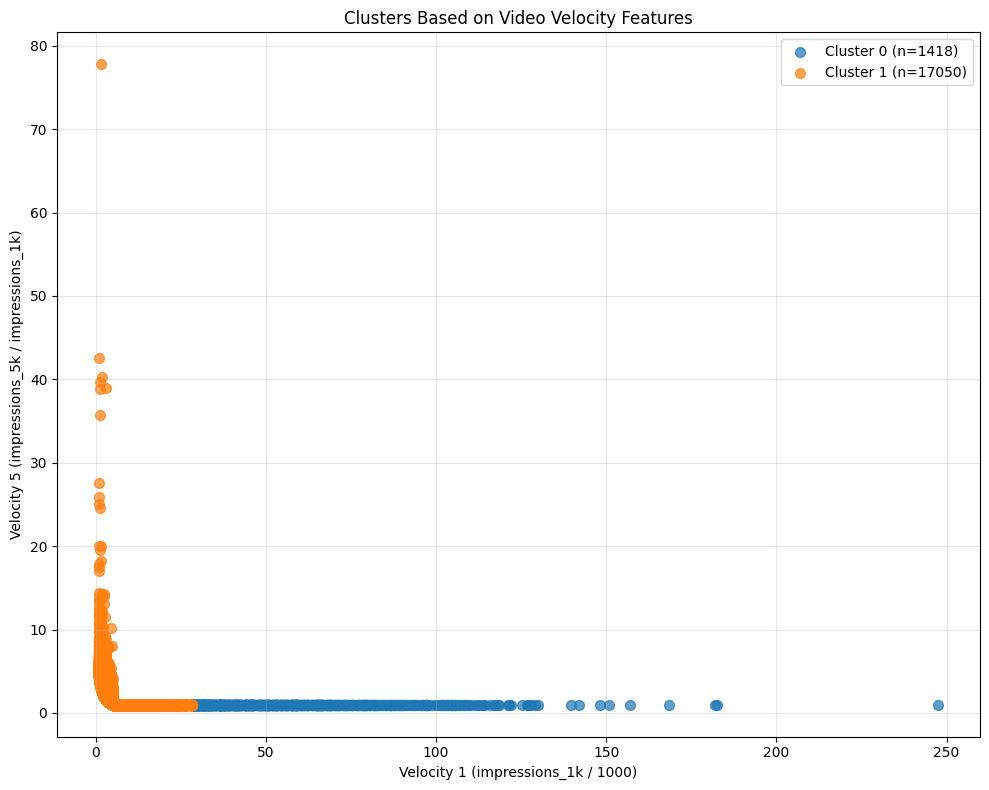


Cluster Characteristics:
           views_final          velocity_1         velocity_5            \
                  mean   median       mean  median       mean    median   
cluster                                                                   
0        407322.691114  69954.0  53.038761  46.318   1.000000  1.000000   
1        223488.471965  26846.5   3.997224   1.688   3.358644  3.428474   

        openrate3s_1k            engrate_1k           video_length         
                 mean    median        mean    median         mean median  
cluster                                                                    
0            0.478802  0.483945    0.030410  0.023467   411.890691  282.0  
1            0.445164  0.440814  263.969787  0.027121   366.334018  297.0  


In [ ]:
# =============================================================================
# 8. Clustering for Specialized Models
# =============================================================================

# Scale velocity features for clustering
scaler_vel = RobustScaler()
X_vel = scaler_vel.fit_transform(df_engineered[velocity_features])

# Find optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_vel)
    silhouette_avg = silhouette_score(X_vel, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# Use the k with highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_engineered['cluster'] = kmeans.fit_predict(X_vel)

# Visualize clusters
plt.figure(figsize=(10, 8))
for cl in range(optimal_k):
    subset = df_engineered[df_engineered['cluster'] == cl]
    plt.scatter(subset['velocity_1'], subset['velocity_5'],
                label=f"Cluster {cl} (n={len(subset)})",
                alpha=0.7, s=50)

plt.xlabel("Velocity 1 (impressions_1k / 1000)")
plt.ylabel("Velocity 5 (impressions_5k / impressions_1k)")
plt.title("Clusters Based on Video Velocity Features")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_stats = df_engineered.groupby('cluster')[['views_final', 'velocity_1', 'velocity_5'] +
                                              ['openrate3s_1k', 'engrate_1k', 'video_length']
                                              if 'video_length' in df_engineered.columns
                                              else []].agg(['mean', 'median'])
print("\nCluster Characteristics:")
print(cluster_stats)


In [ ]:
# =============================================================================
# 9. Train Cluster-Specific Models
# =============================================================================

# Train a separate model for each cluster
cluster_models = {}
cluster_cv_results = {}

print("\nTraining cluster-specific models...")
for cl in range(optimal_k):
    # Get data for this cluster
    cluster_mask = df_engineered['cluster'] == cl
    X_cluster = X[cluster_mask]
    y_cluster = y[cluster_mask]

    if len(X_cluster) < 20:  # Skip very small clusters
        print(f"Cluster {cl} has only {len(X_cluster)} samples - using global model instead")
        cluster_models[cl] = best_model
        continue

    # Create a pipeline for this cluster
    cluster_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', models[best_model_name])  # Use same model type as global best
    ])

    # Evaluate the cluster-specific model
    cluster_cv_results[cl] = evaluate_model(cluster_pipeline, X_cluster, y_cluster, f"Cluster {cl} Model")
    cluster_models[cl] = cluster_pipeline.fit(X_cluster, y_cluster)
    print(f"Cluster {cl} model trained.")
    print(f"  Test MAE: {-np.mean(cluster_cv_results[cl]['test_MAE']):,.2f}")
    print(f"  Test MAPE: {-np.mean(cluster_cv_results[cl]['test_MAPE']):,.2f}%")
    print(f"  Test R²: {np.mean(cluster_cv_results[cl]['test_R2']):.4f}")


Training cluster-specific models...

Cluster 0 Model Performance (5-fold CV):
  Test MAE: 1,087,904.37
  Test MAPE: 112.67%
  Test R²: -163.9029
  Train MAE: 580,399.34
  Train MAPE: 99.39%
Cluster 0 model trained.
  Test MAE: 1,087,904.37
  Test MAPE: 112.67%
  Test R²: -163.9029

Cluster 1 Model Performance (5-fold CV):
  Test MAE: nan
  Test MAPE: nan%
  Test R²: nan
  Train MAE: 1,246,638,450.75
  Train MAPE: 1129413248.60%
Cluster 1 model trained.
  Test MAE: nan
  Test MAPE: nan%
  Test R²: nan
